/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_21036/2950425629.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed

Index(['Both_FVG', 'Volume', 'Target'], dtype='object', name='Price')
                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.948
Date:                Tue, 02 Dec 2025   Prob (F-statistic):             0.0193
Time:                        15:31:09   Log-Likelihood:                -13055.
No. Observations:                8264   AIC:                         2.612e+04
Df Residuals:                    8261   BIC:                         2.614e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

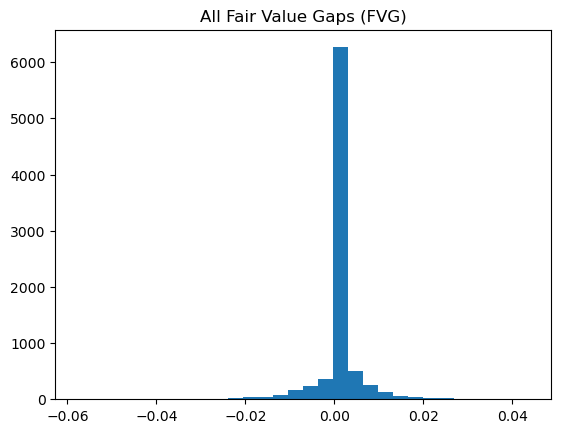

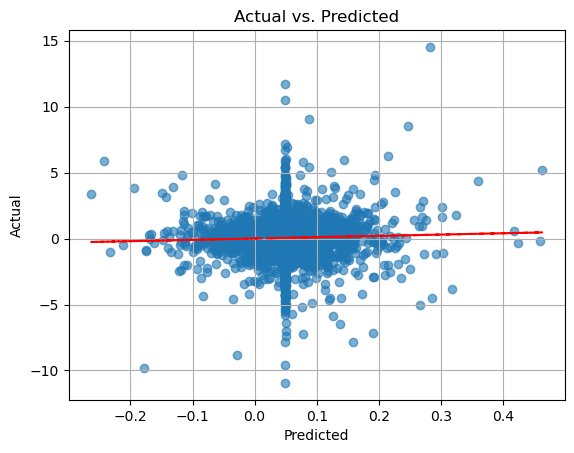

KeyError: "['Both_FVG', 'Volume']"

In [ ]:
# Switching from SciKit Learn Lib to Stats Models Lib for cleaner results

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
    # p-Value is better acessible in this library 
import statsmodels.api as sm

# --- (0) GLOBALEN PARAMETERS ---

# Schritt 1: Ticker
TICKER = "SPY"

# Schritt 2: Preisverhalten 
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

# Schritt 3: Strategie/Unabhängige Variable (FGV)
STRATEGY = ["Both_FVG", "Volume"]

# Schritt 4: Verschieben von Reihen in der Vergangenheit
SHIFT = 1

# Schritt 5: Datenteilmenge (Wie viele Zeilen werden wir analysieren)
LOOKBACK = 10000

# --- (1) Daten herunterladen in df ---

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Daten herunterladen
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Nur Level 0 of Multilevel Columns selecten
    df.columns = df.columns.get_level_values(0)

    # Step 3: df for Plots vereinfachen (Index statt Datum)
    df = df.reset_index(drop=True)

    # Step 4: Nur LOOKBACK Reihen zurückgeben
    return df.iloc[-lookback:, :]

# --- (2) Abhängige Variable ("Target") definieren ---

def add_target(df, shift = SHIFT):

    # Schritt 1: Delta/Preisverhalten definieren (Morgen - Heute), in percentage Terms * 100
    df["Target"] = (df["Close"].shift(-shift) - df["Close"])/df["Close"] * 100

    # Step 2: df zurückgeben 
    return df

# --- (3) Unabhängige Variablen ("Features") definieren ---

def bull_fvg(df):
    # Schritt 1: Berechnet den Höchstpreis von vor 2 Tagen. Wird verwendet, um die Kurslücke (Gap) zu identifizieren.
    df['High_2prev'] = df['High'].shift(2)
    
    # Schritt 2:Prüft auf bullisches FVG (Fair Value Gap): Aktueller Tiefstpreis > Höchstpreis von vor 2 Tagen.
    # Wenn wahr, existiert die Lücke, und der Wert wird auf 1 gesetzt (andernfalls 0).
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    
    # Schritt 3: Berechnet die Größe des FVG, normalisiert durch den aktuellen Schlusskurs.
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    return df 

def bear_fvg(df):
    # Schritt 1: Berechnet den Tiefstpreis von vor 2 Tagen. Wird verwendet, um die Kurslücke (Gap) zu identifizieren.
    df['Low_2prev'] = df['Low'].shift(2)
    
    # Schritt 2: Prüft auf bärisches FVG (Fair Value Gap): Aktueller Höchstpreis < Tiefstpreis von vor 2 Tagen.
    # Wenn wahr, existiert die Lücke, und der Wert wird auf 1 gesetzt (andernfalls 0).
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    
    # Schritt 2: Berechnet die Größe des FVG. Der Wert wird negativ sein.
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    return df

# --- (4) Unabhängige Variablen ("Features") definieren ---

def prepare_df_for_regression(df):
    # Schritt 1: wählt alle Zeilen aus, in denen entweder ein bullisches FVG oder ein bärisches FVG aufgetreten ist-
    #df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
        # Ursprünglicher df hatte 10.000 Handelstage. Wenn nur an 500 Tagen ein FVG auftrat, werden 9.500 Zeilen herausgefiltert.
    
    # Schritt 2: Berechnet den kombinierten FVG-Wert: Summiert den bärischen Wert (der negativ ist) 
    # und den bullischen Wert (der positiv ist). Dies ergibt den Netto-FVG-Wert.
    df['Both_FVG'] = df['Bear_FVG_Val'] + df['Bull_FVG_Val']

    # Schritt 3: Visualisiert die Verteilung aller aufgetretenen FVG-Werte.
    plt.figure()
    plt.hist(df['Both_FVG'], bins=30)
    plt.title('All Fair Value Gaps (FVG)')
    
    return df

def generate_regression_output(df, features=STRATEGY, target="Target"):
    # Step 1: Subset Data. Wählt die Feature- und Target-Spalte aus und entfernt alle Zeilen mit fehlenden Werten (NaN).
    subset = df[features + [target]].dropna()
    print(subset.columns) # Should include all from STRATEGY + target

    # Step 2: Reshape Data and Extract Variables
    # X wird als DataFrame extrahiert, y als Series.
    X = subset[features] 
    y = subset[target] 

    # Step 3: Model Setup (Statsmodels)
    # Fügt eine Konstante (Intercept) zur X-Variable hinzu, da OLS dies separat benötigt.
    X_with_const = sm.add_constant(X)
    
    # Definiert das OLS-Modell (Ordinary Least Squares) und führt die Regression durch (.fit()).
    model = sm.OLS(y, X_with_const).fit() 

    # Step 4: Extract Results
    # Extrahieren des Intercepts (Konstante)
    intercept = model.params['const']
    # Extrahieren der Koeffizienten-Serie (ohne den Intercept)
    coefficients = model.params.drop('const')
    # Extrahieren des R-Squared Wertes
    r2 = model.rsquared
    # Extrahieren der P-Werte (ohne den Intercept)
    p_values = model.pvalues.drop('const')
    # Extrahieren des P-Wertes für das gesamte Modell
    model_p_value = model.f_pvalue # overall model significance
    # Zählt die Beobachtungen
    n_obs = len(subset)
    
    # Generiert die vorhergesagten Werte (Y-Predicted) mit der gelernten Formel.
    y_pred = model.predict(X_with_const) 

    # --- Console summary
    print(model.summary())
    
    # Plot actual vs predicted
    plt.figure()
    # Scatter Plot: Predicted Values (x) vs. Actual Values (y)
    plt.scatter(y_pred, y, alpha=0.6)
    # Zeichnet die ideale 45-Grad-Regressionslinie (y=x) zur visuellen Überprüfung
    plt.plot(y_pred, y_pred, color='red', linestyle='--')
    
    # Beschriftung und Titel
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Actual vs. Predicted")
    plt.grid(True)
    plt.show() # Fügen Sie plt.show hinzu, um die Grafik anzuzeigen

    # Gibt den unveränderten DataFrame (df) und die wichtigsten Ergebnisse zurück.
    return df, intercept, coefficients, model_p_value

# --- (5) VALIDIERUNG DES REGRESSIONSMODELLS ---

def validate_regression_output(df, coefficient, intercept):
    # Berechnung der Vorhersage und des Fehlers (Residuals)
    df["Predictions"] = intercept
    for feature in coef.index:
        df['Residuals'] = df["Target"] - df["Predictions"]

    # Plot 1: Linearität & Homoskedastizität (Voraussetzung für die Regression)
    # Scatter Plot: Predicted Values vs. Residuals (Fehler).
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    # Curve Shape = Non-Linear Relationship (x) | Fanning = Heteroscedastic (x)
    plt.title('(1) & (3) Testing for Linearity & Homoscedasticity: Relationship Between Residuals and Predicted Values \n Curve Shape = Non-Linear Relationship - x \n Fanning = Heteroscedastic - x')
    
    # Plot 2: Autokorrelation (Unabhängigkeit der Fehler)
    # Lag Plot: Fehler heute vs. Fehler gestern. Sollte keine offensichtliche Struktur zeigen.
    plt.figure()
    lag_plot(df['Residuals'].dropna()) 
    plt.title('(2) Testing for Independence: Lag Plot of Residuals \n No Obvious Relationship - Autocorrelation - x')

    # Plot 3: Normalität der Residuals (Glockenkurvenform)
    # Histogram: Zeigt die Verteilung der Fehler. Sollte annähernd normalverteilt sein.
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('(4) Testing for Normality: Distribution of Residuals \n No Skew - Non-Normal - x') 

    return df

# --- HAUPT-EXECUTION (MAIN) ---

def main():
    # Annahme: Diese Schritte laden und bereiten die Daten vor
    df = get_data()
    df = add_target(df) 
    df = bull_fvg(df) 
    df = bear_fvg(df)
    df = prepare_df_for_regression(df)
    # Regression durchführen und Ergebnisse zuweisen
    # Annahme: generate_regression_output gibt df, intercept und coefficient zurück.
    df, fit_intercept, fit_coefficient, model_pval = generate_regression_output(df) 
    # 1. Statistische Validierung der Regression (visuell)
    df = validate_regression_output(df, fit_coefficient, fit_intercept) 
    
    print(f"\n[Overall Model Significance] p-value = {model_pval:.6f}")

    return df

df = main()
df